# Scrubbing Our Data - Lab

## Introduction

In the previous labs, we joined the data from our separate files into a single DataFrame.  In this lab, we'll scrub the data to get it ready for exploration and modeling!

## Objectives

You will be able to:

* Cast columns to the appropriate data types
* Identify and deal with null values appropriately
* Remove unnecessary columns
* Understand how to normalize data


## Getting Started

You'll find the resulting dataset from our work in the _Obtaining Data_ Lab stored within the file `walmart_data_not_cleaned.csv`.  

In the cells below:

* Import pandas and set the standard alias
* Import numpy and set the standard alias
* Import matplotlib.pyplot and set the standard alias
* Import seaborn and set the alias `sns` (this is the standard alias for seaborn)
* Use the ipython magic command to set all matplotlib visualizations to display inline in the the notebook
* Load the dataset stored in the .csv file into a DataFrame using pandas
* Inspect the head of the DataFrame to ensure everything loaded correctly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
df = pd.read_csv('walmart_data_not_cleaned.csv')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


Great! Everything looks just like we left it as.  Now, we can begin cleaning the data. 

Before we jump right into data cleaning,. we'll want to consider our process first.  Answer the following questions below:

What sorts of problems should we be checking for?  Are there any obvious issues that we'll need to deal with? What are some other issues that this dataset could contain that might not be immediately obvious?  

Write your answer below this line:
_____________________________________________________________________________________________________________________________________
We are looking for null values, and we need to make sure all of the columns are of the appropriate type.  We need to remove any columns that are unnecesary. Then look for multicolinearity and normalize the data.  The markdown cloumns look like they are all null values and that will have to be dealt with first.  Catagorical columns will need to be one-hot encoded before checking for multicolinearity.

 

## Dealing with Oversized Datasets

This dataset is quite large. Often, when starting out on a project, its a good idea to build the model on a subset of the data so that we're not bogged down by large runtimes. Let's investigate the dataset a bit to get a feel for if this is a good idea. 

In the cell below, check how many rows this dataset contains.

In [4]:
df.shape

(421570, 16)

This dataset contains `421570` rows! That's large enough that we should consider building our model on a subset of the data to increase our speed during the modeling step.  Modeling is an iterative process, and we'll likely have to fit out model multiple times as we tweak it--by subsetting our dataset, we'll protect ourselves from insane runtimes everytime we make a small change and need to rerun our model. Once we have a prototype built, we can always add all the extra data back in!

### Subsetting our Dataset

The typical method for subsetting our dataset is to just take a random sample of data.  This is an option for us.  However, when we inspect the columns of our dataset in a bit, we'll notice that we have 2 categorical columns with very high cardinality--`Store`, and `Dept`.  This provides us with an opportunity to reduce dimensionality while subsampling.  Instead of building a model on all the stores and departments in our dataset, we'll subset our data so that it only contains stores 1 through 10.  

In the cell below, slice our dataset so that only rows with a `Store` value between 1 and 10 (inclusive) remain. 

In [7]:
df = df[df['Store'] <= 10]

In [8]:
len(df)

97839

## Starting our Data Cleaning

We'll begin by dealing with the most obvious issues--data types and null values. 

First, we'll check the different types of encoding that each column has, and then we'll check for null values and examine our options for dealing with them.

### Checking Data Types

In the cell below, use the appropriate method to check the data type of each column. 

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97839 entries, 0 to 97838
Data columns (total 16 columns):
Store           97839 non-null int64
Dept            97839 non-null int64
Date            97839 non-null object
Weekly_Sales    97839 non-null float64
IsHoliday       97839 non-null bool
Type            97839 non-null object
Size            97839 non-null int64
Temperature     97839 non-null float64
Fuel_Price      97839 non-null float64
MarkDown1       35013 non-null float64
MarkDown2       27232 non-null float64
MarkDown3       32513 non-null float64
MarkDown4       34485 non-null float64
MarkDown5       35013 non-null float64
CPI             97839 non-null float64
Unemployment    97839 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 12.0+ MB


Let's investigate the unique values inside of the `Store` and `Dept` columns.

In the cells below, use the appropriate DataFrame method to display all the unique values in the `Store` column, and in the `Dept` column. 

In [14]:
df.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [15]:
df.Dept.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56,
       58, 59, 60, 67, 71, 72, 74, 79, 80, 81, 82, 83, 85, 87, 90, 91, 92,
       93, 94, 95, 97, 98, 78, 96, 99, 77, 39, 50])

### Categorical Data Stored as Integers

A common issue we usually check for at this stage is numeric columns that have accidentally been encoded as strings.  However, in this dataset, we'll notice that although the `Store` and `Dept` columns are both contain integer values, we can intuit that these are meant to be read as categorical data.  We'll want to convert these columns to strings, so that they will be one-hot encoded when we get around to dealing with our categorical columns.  

You may be wondering why we don't just leave it as is.  This is because we would accidentally be creating numeric relationships between the different stores that shouldn't be there.  If left with numeric encoding, our model would interpret Store 2 as twice Store 1, but half of Store 4.  These sorts of mathematical relationships don't make sense--we'd much rather these be treated as categories, as the dataset intends.  

In the cell below, cast the `Store` and `Dept` columns to strings. 

In [17]:
df.Store = df.Store.astype(str)
df.Dept = df.Dept.astype(str)

### Numeric Data Stored as Strings

It looks like we have two columns that are encoded as strings (remember, pandas denotes string columns as `object`)--`Date` and `Type`.

We don't need to worry about `Date`--those should obviously be encoded as strings. Let's quickly check out the `Type` column just to ensure that it doesn't contain numeric data.

In the cell below, get the unique values contained within the `Type` column. 

In [18]:
df.Type.unique()

array(['A', 'B'], dtype=object)

Great job--the `Type` column is clearly a categorical column, and should currently be stored as a string.  Once we've dealt with null values, we'll deal with this and other categorical columns by one-hot encoding them. 

Let's double check the column encodings one more time to make sure that everything we did above worked correctly. 

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97839 entries, 0 to 97838
Data columns (total 16 columns):
Store           97839 non-null object
Dept            97839 non-null object
Date            97839 non-null object
Weekly_Sales    97839 non-null float64
IsHoliday       97839 non-null bool
Type            97839 non-null object
Size            97839 non-null int64
Temperature     97839 non-null float64
Fuel_Price      97839 non-null float64
MarkDown1       35013 non-null float64
MarkDown2       27232 non-null float64
MarkDown3       32513 non-null float64
MarkDown4       34485 non-null float64
MarkDown5       35013 non-null float64
CPI             97839 non-null float64
Unemployment    97839 non-null float64
dtypes: bool(1), float64(10), int64(1), object(4)
memory usage: 12.0+ MB


### Detecting and Dealing With Null Values

 Next, we'll need to check for null values. How we deal with the null values will be determined by the columns containing them, and how many null values exist in each.  
 
 In the cell below, use the appropriate pandas functionality to get a count of how many null values exist in each column in our DataFrame. 

In [23]:
df.isna().sum()

Store               0
Dept                0
Date                0
Weekly_Sales        0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1       62826
MarkDown2       70607
MarkDown3       65326
MarkDown4       63354
MarkDown5       62826
CPI                 0
Unemployment        0
dtype: int64

**_QUESTION:_** Interpret the output above.  Do we know enough to have a strategy for dealing with these null values yet? Is dropping the rows a valid solution?  How about dropping the columns?  Can we replace them with interpolation, treat them as a categorical value, or deal with them through binning?  

Write your answer below this line:
________________________________________________________________________________
Dropping the rows isnt a good option because we would lose a lot of our useful data.  Dropping all of the markdown columns is also not the best option at this point because we dont know what the data in those values contains yet.  We need to investigate what the markdown columns contain and figure out if we should drop them or bin, and one-hot encode them to make them catagorical.


Let's investigate these columns further.  In the cell below, get the top 20 value counts contained within `MarkDown3`.

In [24]:
df.MarkDown3.value_counts()

3.00     403
1.00     331
6.00     277
1.65     217
2.97     208
2.00     197
2.02     197
0.55     193
10.80    145
8.11     145
24.60    144
4.20     141
4.26     140
6.50     140
3.20     137
0.22     136
1.88     136
6.01     135
17.36    134
0.25     134
7.50     133
3.39     133
0.50     133
0.60     132
2.20     132
3.72     130
4.00     128
0.24     127
3.01     127
1.71     126
        ... 
0.51      62
22.74     62
1.04      62
6.48      62
24.70     62
41.58     62
0.68      62
5.85      62
2.46      62
0.70      62
4.54      62
50.03     62
4.46      62
30.92     62
1.40      62
10.00     62
30.18     62
65.34     62
42.75     61
13.00     61
10.75     61
1.80      61
8.08      61
0.36      61
52.06     61
12.00     61
6.02      61
9.61      61
68.00     61
2.31      60
Name: MarkDown3, Length: 425, dtype: int64

Now, let's get the descriptive statistics for each of the markdown columns. We want to see where the minimum and maximum values lie.  

In [26]:
df.MarkDown1.describe()

count    35013.000000
mean      7048.166982
std       7656.783543
min         35.940000
25%       2639.050000
50%       5126.540000
75%       8813.810000
max      75149.790000
Name: MarkDown1, dtype: float64

In [27]:
df.MarkDown2.describe()

count     27232.000000
mean       3210.994407
std       10683.244951
min         -10.980000
25%          24.030000
50%         148.950000
75%        1555.570000
max      104519.540000
Name: MarkDown2, dtype: float64

In [28]:
df.MarkDown3.describe()

count     32513.000000
mean       1553.120097
std       10595.395278
min           0.010000
25%           4.530000
50%          21.120000
75%          96.350000
max      141630.610000
Name: MarkDown3, dtype: float64

In [29]:
df.MarkDown4.describe()

count    34485.000000
mean      2934.328386
std       5199.795541
min          4.000000
25%        426.510000
50%       1183.640000
75%       3463.030000
max      48159.860000
Name: MarkDown4, dtype: float64

In [30]:
df.MarkDown5.describe()

count    35013.000000
mean      4706.398300
std       5347.922707
min        135.160000
25%       2007.500000
50%       3592.820000
75%       5630.400000
max      58068.140000
Name: MarkDown5, dtype: float64

Okay--let's examine what we know about these columns, and come up with a solution for dealing with these null values. 

* The data contained within each column are continuously-valued floats. 
* The range is quite large, with the smallest value being around 0 or even negative in some columns, and the max being greater than 100,000.
* There is extremely high variance in each, with the standard deviation being larger than the mean in all 5 columns. 


### Dealing With Null Values Through Binning

This suggests that our best bet is to bin the columns.  The hard part is figuring out the right amount of bins to use.  Too many, and we subject ourselves to the curse of dimensionality.  Too few, and we lose information from the columns that could be important. 

For now, let's start with with 5 bins of equal size. 

In the cell below: 

* Create a binned version of each `MarkDown` column and add them to our DataFrame.  
* When calling `pd.cut()`, pass in the appropriate column as the object to be binned, the number of bins we want, `5`, and set the `labels` parameter to `bins`, so that we have clearly labeled names for each bin. 

For more information on how to bin these columns using pd.cut, see the [pandas documentation for this method.](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.cut.html)

In [34]:
bins = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']

for i in range (1, 6):
    df["binned_markdown_" + str(i)] = pd.cut(df['MarkDown' + str(i)], 5, labels=bins)

Great! Now, let's check the `.dtypes` attribute of our DataFrame to see that these new categorical columns have been created. 

In [38]:
df.dtypes

Store                  object
Dept                   object
Date                   object
Weekly_Sales          float64
IsHoliday                bool
Type                   object
Size                    int64
Temperature           float64
Fuel_Price            float64
MarkDown1             float64
MarkDown2             float64
MarkDown3             float64
MarkDown4             float64
MarkDown5             float64
CPI                   float64
Unemployment          float64
binned_markdown_1    category
binned_markdown_2    category
binned_markdown_3    category
binned_markdown_4    category
binned_markdown_5    category
dtype: object

They exist! However, they still contain null values.  We need to replace all null values with a string that will represent all missing values.  This is easy enough for us--we can just use the `replace()` method or the `fillna()` method on each column and replace `NaN` with `"NaN"`. 

In the cell below, replace all missing values inside our `binned_markdown` columns with the string `"NaN"`.

**_NOTE:_** If you're unsure of how to do this, check the [pandas documentation for replace](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html).

In [44]:
for i in range (1,6):
    df['binned_markdown_' + str(i)].replace(np.NaN,'NaN', inplace=True)

Great! Now, let's check if those columns still contain null values. 

In the cell below, display the number of null values contained within each column of our DataFrame.

In [45]:
df.isna().sum()

Store                    0
Dept                     0
Date                     0
Weekly_Sales             0
IsHoliday                0
Type                     0
Size                     0
Temperature              0
Fuel_Price               0
MarkDown1            62826
MarkDown2            70607
MarkDown3            65326
MarkDown4            63354
MarkDown5            62826
CPI                      0
Unemployment             0
binned_markdown_1        0
binned_markdown_2        0
binned_markdown_3        0
binned_markdown_4        0
binned_markdown_5        0
dtype: int64

Excellent! We've now dealt with all the null values in our dataset through **_Coarse Classification_** by binning our data and treating null values as a distinct category. All that's left to do is to drop our original `MarkDown` columns from the DataFrame. 

Note that in this step, we'll also drop the `Date` column, because we are going to build a generalized model and will not be making use of any time series data. 

In the cell below:

* Create a list called `to_drop` that contains the name of every `MarkDown` column we need to drop (for a challenge, try doing this with a list comprehension!)
* Append `"Date"` to `to_drop`
* Drop these columns (in place) from our DataFrame
* Display the number of null values in each column again to confirm that these columns have been dropped, and that our DataFrame now contains no missing values


In [47]:
to_drop = ['MarkDown' + str(i) for i in range(1, 6)]
to_drop.append('Date')
df.drop(to_drop, axis=1, inplace=True)
df.isna().sum()

Store                0
Dept                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
CPI                  0
Unemployment         0
binned_markdown_1    0
binned_markdown_2    0
binned_markdown_3    0
binned_markdown_4    0
binned_markdown_5    0
dtype: int64

### Checking for Multicollinearity


Before we one-hot encode our categorical columns, we'll want to quickly check the dataset for multicollinearity, since this can really mess up our model if it exists in the dataset.  We want to make sure that the columns within the dataset are not highly correlated. 

We'll do this by creating a correlation heatmap. We want to do this before one-hot-encoding our data because each column becomes both a row and a column in the visualization, and after one-hot encoding, this dataset will contain over 300 columns!

The [seaborn documentation](https://seaborn.pydata.org/examples/many_pairwise_correlations.html) provides some great code samples to help us figure out how to display a Correlation Heatmap.  

Check out this documentation, and then modify the code included so that it displays a Correlation Heatmap for our dataset below.

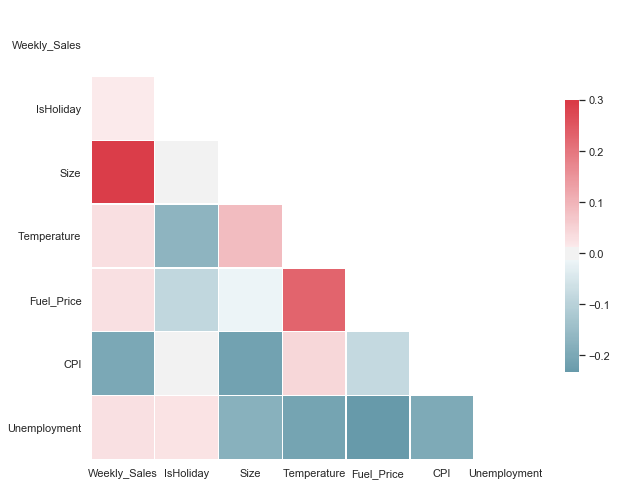

In [48]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = df.corr()

# Generate a mask the size of our ovariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink':.5})

Interpret the Correlation Heatmap we created above to answer the following questions:

Which columns are highly correlated with the target column our model will predict?  Are any of our predictor columns highly correlated enough that we should consider dropping them?  Explain your answer.

Write your answer below this line:
________________________________________________________________________________________________________________________________Size is the most correlated with weekly_sales which is our target variable.  There isnt enough correlation with the other predictors to necesitate removing them. 



## Normalizing our Data

Now, we'll need to convert all of our numeric columns to the same scale by **_normalizing_** our dataset.  Recall that we normalize our dataset by converting each numeric value to it's corresponding z-score for the column, which is obtained by subtracting the column's mean and then dividing by the column's standard deviation for every value. 

Since we only have 4 columns containing numeric data that needs to be normalized, we'll do this by hand in the cell below. This allows us to avoid errors that stem from trying to normalize datasets that contain strings in all of our categorical columns. Plus, it's good practice to help us remember how normalization works!

In the cell below:

* Normalize the following columns individually: `Size`, `Temperature`, `Fuel_Price`, `CPI`, and `Unemployment` by subtracting the column mean and dividing by the column standard deviation. 

In [49]:
df.Size = (df.Size - df.Size.mean()) / df.Size.std()
df.Temperature = (df.Temperature - df.Temperature.mean())/ df.Temperature.std()
df.Fuel_Price = (df.Fuel_Price - df.Fuel_Price.mean()) / df.Fuel_Price.std()
df.CPI = (df.CPI - df.CPI.mean()) / df.CPI.std()
df.Unemployment = (df.Unemployment - df.Unemployment.mean()) / df.Unemployment.std()

## One-Hot Encoding Categorical Columns

For our final step, we'll need to deal with our categorical columns.  Categorical data work work for our modeling step--we'll need to convert these to numeric columns through **_one-hot encoding_**.  

In the cell below, use the [appropriate function in pandas](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) to one-hot encode the dataset.

In [50]:
df = pd.get_dummies(df)

In [51]:
df.head()

,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,CPI,Unemployment,Store_1,Store_10,Store_2,...,binned_markdown_4_41-60%,binned_markdown_4_61-80%,binned_markdown_4_81-100%,binned_markdown_4_NaN,binned_markdown_5_0-20%,binned_markdown_5_21-40%,binned_markdown_5_41-60%,binned_markdown_5_61-80%,binned_markdown_5_81-100%,binned_markdown_5_NaN
0,24924.50,False,0.283436,-1.301205,-1.56024,0.40349,0.913194,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,50605.27,False,0.283436,-1.301205,-1.56024,0.40349,0.913194,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,13740.12,False,0.283436,-1.301205,-1.56024,0.40349,0.913194,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,39954.04,False,0.283436,-1.301205,-1.56024,0.40349,0.913194,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,32229.38,False,0.283436,-1.301205,-1.56024,0.40349,0.913194,1,0,0,...,0,0,0,1,0,0,0,0,0,1


That's it! We've now successfully scrubbed our dataset--we're now ready for data exploration and modeling.

## Conclusion

In this lesson, we learned gain practice with data cleaning by:

* Casting columns to the appropriate data types
* Identifying and deal with null values appropriately
* Removing unnecessary columns
* Checking for and deal with multicollinearity
* Normalizing our data